# Analysis of Preprint Papers from the ArXiv

The website [arxiv.org](https://arxiv.org) is a popular database for scientific papers in STEM fields. ArXiv has its own classification system consisting of roughly 150 different categories, which are manually added by the authors whenever a new paper is uploaded. A paper can be assigned multiple categories.

The goal for this project is to develop a machine learning model which can predict the ArXiv category from a given title and abstract.

We start by importing all the packages we will need and setting up a data directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA # dimension reduction of data
import pickle

# local files
import arxiv_scraper
import cleaner
import elmo
import NN
import onehot

print("Packages loaded.")

Packages loaded.


The data set used here has been scraped from the [ArXiv API](https://arxiv.org/help/api) over several days, using the Python scraper `arxiv_scraper.py`. To get a sense for how long the scraping takes, you can uncomment and run the script below.

In [2]:
#arxiv_scraper.cat_scrape(
#    max_results_per_cat = 100, # maximum number of papers to download per category (there are ~150 categories)
#    file_path = "arxiv_data", # name of output file
#    batch_size = 100 # size of every batch - lower batch size requires less memory - must be less than 30,000
#)

Alternatively, I have downloaded metadata from about a million papers using this scraper (with `max_results_per_cat` = 10000), which can be freely downloaded below. This data set takes up ~1gb of space, however, so I've included many random samples of this data set as well:

* `arxiv` contains the main data set
* `arxiv_sample_1000` contains 1,000 papers
* `arxiv_sample_5000` contains 5,000 papers
* `arxiv_sample_10000` contains 10,000 papers
* `arxiv_sample_25000` contains 25,000 papers
* `arxiv_sample_50000` contains 50,000 papers
* `arxiv_sample_100000` contains 100,000 papers
* `arxiv_sample_200000` contains 200,000 papers
* `arxiv_sample_500000` contains 500,000 papers
* `arxiv_sample_750000` contains 750,000 papers

Choose your favorite below. Alternatively, of course, you can set it to be the file name of your own scraped data.

In [3]:
file_name = "arxiv_sample_5000"

Next up, we specify the folder in which we will store all our data. Change to whatever folder you would like.

In [4]:
data_path = os.path.join("/home", "dn16382", "pCloudDrive", "Public Folder", "scholarly_data")

## Fetching data

We then do some basic setting up.

In [5]:
# create path directory and download a list of all arXiv categories
cleaner.setup(data_path)

# download the raw titles and abstracts
cleaner.download_papers(file_name, data_path)

cats.csv is already downloaded.
arxiv_sample_5000.csv is already downloaded.


Next, we store the list of arXiv categories.

In [6]:
# construct category dataframe and array
full_path = os.path.join(data_path, "cats.csv")
cats_df = pd.read_csv(full_path)
cats = np.asarray(cats_df['category'].values)

pd.set_option('display.max_colwidth', 50)
cats_df.head()

,category,description
0,astro-ph,Astrophysics
1,astro-ph.CO,Cosmology and Nongalactic Astrophysics
2,astro-ph.EP,Earth and Planetary Astrophysics
3,astro-ph.GA,Astrophysics of Galaxies
4,astro-ph.HE,High Energy Astrophysical Phenomena


## Cleaning the data

We now do some basic cleaning operations on our raw data. We convert strings '\[cat_1, cat_2\]' into actual lists \[cat_1, cat_2\], make everything lower case, removing punctuation, numbers and whitespace, and dropping NaN rows.

Our last text cleaning step is to lemmatise the text, which reduces all words to its base form. For instance, 'eating' is converted into 'eat' and 'better' is converted into 'good'. This usually takes a while to finish, so instead we're simply going to download a lemmatised version of your chosen data set. Alternatively, if you're dealing with your own scraped data set, you can uncomment the marked lines below.

In [7]:
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
if not os.path.isfile(full_path):
    # preclean raw data and save the precleaned texts and
    # categories to {file_name}_preclean.csv
    cleaner.get_preclean_text(file_name, data_path)

    # lemmatise precleaned data and save lemmatised texts to 
    # {file_name}_clean.csv and delete the precleaned file
    cleaner.lemmatise_file(file_name, batch_size = 1000, path = data_path, confirmation = False)

# load in cleaned text
print("Loading cleaned text...")
full_path = os.path.join(data_path, f"{file_name}_clean.csv")
clean_text = pd.read_csv(full_path, delimiter = '\n', header = None)
clean_df = pd.DataFrame(clean_text)
clean_df.columns = ['clean_text']

# load in cats and add them to df
full_path = os.path.join(data_path, f"{file_name}.csv")
clean_cats_with_path = lambda x: cleaner.clean_cats(x, path = data_path)
cleaned_cats = pd.read_csv(full_path, header = None, converters = {0 : clean_cats_with_path})

# join the two dataframes
clean_df['category'] = cleaned_cats.iloc[:, 0]

print(f"Shape of clean_df: {clean_df.shape}. Here are some of the lemmatised texts:")
pd.set_option('display.max_colwidth', 1000)
clean_df[['clean_text', 'category']].head()

Loading cleaned text...
Shape of clean_df: (5000, 2). Here are some of the lemmatised texts:


,clean_text,category
0,"what can the alignment of the velocity moment tell -PRON- about the nature of the potential ? -PRON- prove that , if the time - independent distribution function $ f(v;x)$ of a steady - state stellar system be symmetric under velocity inversion such that $ f(-v _ , v _ , v _ ; x)=f(v _ , v _ , v _ ; x)$ and the same for $ v _ $ and $ v _ $ , where $ ( v _ , v _ , v _ ) $ be the velocity component project onto an orthogonal frame , then the potential within which the system be in equilibrium must be separable ( i.e. the staeckel potential ) . furthermore , -PRON- find that the jean equation imply that , if all mixed second moment of the velocity vanish , that is , $ \langle v_iv_j\rangle= $ for any $ i\ne j$ , in some staeckel coordinate system and the only non - vanish fourth moment in the same coordinate be those in the form of $ \langle v_i^ \rangle$ or $ \langle v_i^ v_j^ \rangle$ , then the potential must be separable in the same coordinate . finally -PRON- also show that all s...",NaN
1,"surface charge for gravity and electromagnetism in the first order formalism a new derivation of surface charge for + gravity couple to electromagnetism be obtain . gravity theory be write in the tetrad - connection variable . the general derivation start from the lagrangian and use the covariant symplectic formalism in the language of form . for gauge theory surface charge disentangle physical from gauge symmetry through the use of noether identity and the exactness symmetry condition . the surface charge be quasilocal , explicitly coordinate independent , gauge invariant , and background independent . for a black hole family solution the surface charge conservation imply the first law of black hole mechanic . as a check -PRON- show the first law for black hole electrically charge , rotate , and with an asymptotically constant curvature ( the kerr - newman ( anti-)de sitter family ) . the charge , include the would - be mass term appear in the first law , be quasilocal . -PRON- be...",NaN
2,"harmonic generation and intense terahertz radiation from polar molecule at multiphoton resonant excitation in laser field the coherent radiation spectrum of two - level polar molecule with uv transition be study at the multiphoton resonant excitation by a moderately strong laser field . the spectrum correspond to harmonic generation and low - frequency radiation be investigate both analytically and numerically . specifically , a mechanism for generation of intense smoothly tunable terahertz radiation by two - level molecular configuration ( with dynamic stark shift ) possess permanent dipole moment , be consider .",NaN
3,"towards a classification of compact quantum group of lie type this be a survey of recent result on classification of compact quantum group of lie type , by which -PRON- mean quantum group with the same fusion rule and dimension of representation as for a compact connected lie group $ g$. the classification be base on a categorical duality for quantum group action recently develop by de commer and the author in the spirit of woronowicz 's tannaka -- krein duality theorem . the duality establish a correspondence between the action of a compact quantum group $ h$ on unital c$^*$-algebra and the module category over -PRON- representation category rep $ h$. this be further refined to a correspondence between the braid - commutative yetter -- drinfeld $ h$-algebras and the tensor functor from rep $ h$. combine with the more analytical theory of poisson boundary , this lead to a classification of dimension - preserve fiber functor on the representation category of any coamenable compact q...",NaN
4,"modeling and analysis of two - way relay non - orthogonal multiple access system a two - way relay non - orthogonal multiple access ( twr - noma ) system be investigate , where two group of noma user exchange message with the aid of one half - duplex ( hd ) decode - and - forward ( df ) relay . since the signal - plus - 

## ELMo feature extraction

To build our model we have to extract features from the titles and abstracts. We will be using ELMo, a state-of-the-art NLP framework developed by AllenNLP, which converts text input into vectors, with similar words being closer to each other. We will first download the ELMo model. It is over 350mb in size, so it might take a little while.

In [8]:
elmo.download_elmo_model()

ELMo model already downloaded.


We now need to extract ELMo features from our cleaned text data. This is done using the `extract` function from `elmo.py`. This usually takes a LONG time.

In [9]:
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
if not os.path.isfile(full_path):
    # extract ELMo data
    elmo.extract(
        file_name = file_name,
        path = data_path,
        batch_size = 20, # lower batch size gives less accurate vectors but requires less memory
        doomsday_clock = 50,
        confirmation = False
    )

# load ELMo data
print("Loading ELMo'd text...")
full_path = os.path.join(data_path, f"{file_name}_elmo.csv")
elmo_data = pd.read_csv(full_path, header = None)
print(f"ELMo data loaded from {full_path}.")

elmo_df = clean_df.copy()
elmo_df = elmo_data.join(elmo_df['category'])

print(f"Shape of elmo_df: {elmo_df.shape}")
elmo_df.head()

Loading ELMo'd text...
ELMo data loaded from /home/dn16382/pCloudDrive/Public Folder/scholarly_data/arxiv_sample_5000_elmo.csv.
Shape of elmo_df: (5000, 1025)


,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,category
0,0.187667,0.258786,0.074989,-0.099943,0.096569,-0.119423,-0.031600,0.301296,-0.089893,-0.028463,...,0.107814,0.106341,0.035994,0.378528,-0.034695,0.440142,-0.058051,0.307372,0.034355,NaN
1,0.227111,0.333600,-0.062285,-0.125636,-0.086900,-0.165064,-0.103290,0.392624,0.272809,-0.250590,...,0.180015,0.136054,0.196562,0.295752,0.092888,0.488284,-0.028830,0.309929,0.015871,NaN
2,0.063942,0.125402,0.023198,0.034770,0.011070,-0.101817,-0.031062,0.079317,0.082320,-0.150926,...,-0.016082,0.067077,0.087602,0.168904,0.032571,0.286112,-0.021735,0.153371,0.010388,NaN
3,0.080030,0.218094,0.037845,-0.101031,0.096396,-0.059034,-0.047065,0.328634,0.024202,-0.270140,...,0.117777,0.028279,0.098030,0.153427,-0.101384,0.328519,-0.137936,0.341988,0.002515,NaN
4,0.090861,0.428467,-0.241917,0.087071,0.172179,-0.140665,-0.253924,0.240128,0.509340,-0.206757,...,0.234183,0.083604,0.072291,0.310742,0.005294,0.875694,-0.245994,0.300683,0.033284,NaN


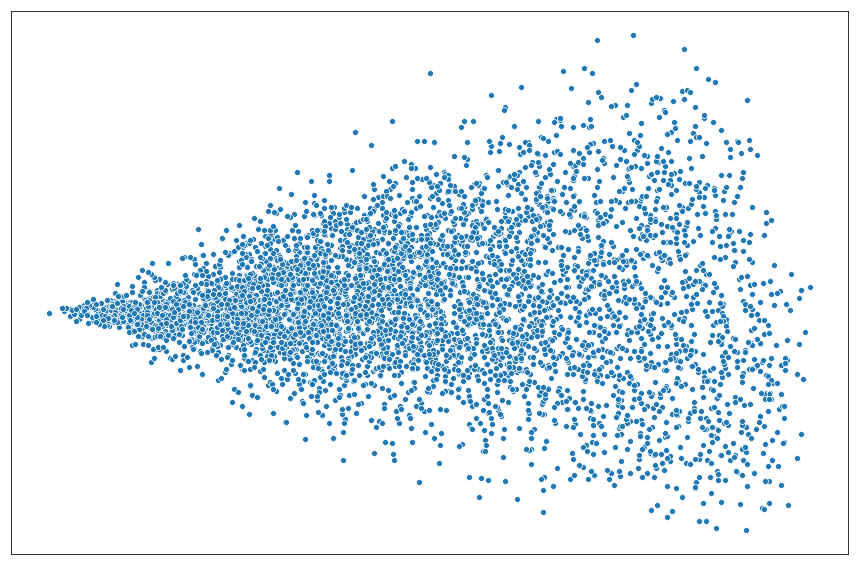

In [10]:
n = elmo_df.shape[1] - 1
X = np.asarray(elmo_df.iloc[:, :n])
X_2d = PCA(n_components = 2).fit_transform(X)
elmo_2d = pd.DataFrame(X_2d, columns = ['x', 'y'])

fig, ax = plt.subplots(1, figsize = (15, 10))
ax.set_xticks([])
ax.set_yticks([])
sns.scatterplot(data = elmo_2d, x = 'x', y = 'y')

## One-hot encoding of categories

We then perform a one hot encoding for the category variable, as this will make training our model easier. We do this by first creating a dataframe with columns the categories and binary values for every paper, and then concatenate our original dataframe with the binary values.

In [11]:
# one-hot encode aggregated categories
onehot.one_hot_agg(file_name, data_path)

# load data
print("Loading aggregated category data...")
full_path = os.path.join(data_path, f"{file_name}_1hot_agg.csv")
df_1hot_agg = pd.read_csv(full_path)
print(f"Aggregated category data loaded.")

# show the new columns of the data frame
pd.set_option('display.max_colwidth', 10)
print(f"Dimensions of df_1hot_agg: {df_1hot_agg.shape}.")
df_1hot_agg.head()

File already one-hot encoded.
Loading aggregated category data...
Aggregated category data loaded.
Dimensions of df_1hot_agg: (5000, 1029).


,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,physics,other,cs,math,stats
0,0.187667,0.258786,0.074989,-0.099943,0.096569,-0.119423,-0.031600,0.301296,-0.089893,-0.028463,...,-0.034695,0.440142,-0.058051,0.307372,0.034355,1,0,0,1,0
1,0.227111,0.333600,-0.062285,-0.125636,-0.086900,-0.165064,-0.103290,0.392624,0.272809,-0.250590,...,0.092888,0.488284,-0.028830,0.309929,0.015871,1,0,0,0,0
2,0.063942,0.125402,0.023198,0.034770,0.011070,-0.101817,-0.031062,0.079317,0.082320,-0.150926,...,0.032571,0.286112,-0.021735,0.153371,0.010388,1,0,0,0,0
3,0.080030,0.218094,0.037845,-0.101031,0.096396,-0.059034,-0.047065,0.328634,0.024202,-0.270140,...,-0.101384,0.328519,-0.137936,0.341988,0.002515,0,0,0,1,0
4,0.090861,0.428467,-0.241917,0.087071,0.172179,-0.140665,-0.253924,0.240128,0.509340,-0.206757,...,0.005294,0.875694,-0.245994,0.300683,0.033284,0,0,1,1,0


## Analysis of the data

Here is how the categories in our data set are distributed.

We see that our data is not particularly uniformly distributed. These are the categories with the most amount of papers in the data set.

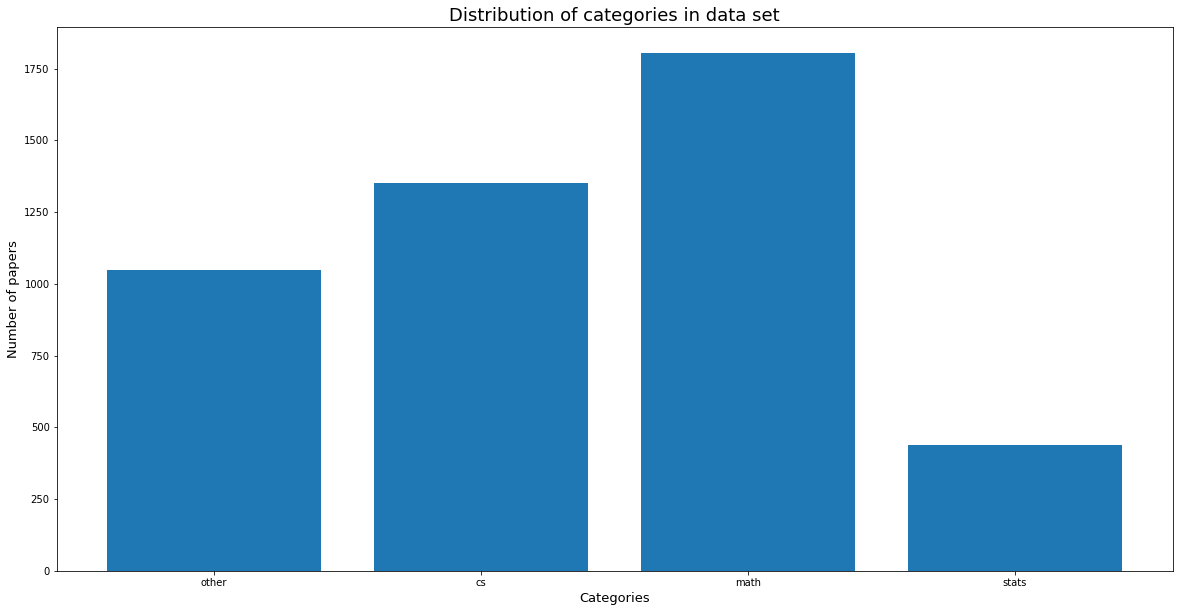

In [12]:
# save a dataframe with the amount of papers in each category
sum_cats = df_1hot_agg.iloc[:, 1025:].apply(lambda x: x.sum())

# plot the distribution of the amount of papers in each category
plt.figure(figsize = (20,10))
plt.bar(x = sum_cats.keys(), height = sum_cats.values)
plt.xlabel('Categories', fontsize = 13)
plt.ylabel('Number of papers', fontsize = 13)
plt.title('Distribution of categories in data set', fontsize = 18)
plt.show()

## Building a model

We are now done manipulating our data, and the time has come to build a model.

In [13]:
full_path = os.path.join(data_path, f'{file_name}_model_1000.pickle')
if os.path.isfile(full_path):
    with open(full_path, 'rb') as pickle_in:
        nn_model = pickle.load(pickle_in)
else:
    nn_model = NN.NeuralNetwork(
        layer_dims = [500, 5],
        activations = ['tanh', 'sigmoid'],
        learning_rate = 0.0075,
        num_iterations = 1000,
        cost_function = 'cross_entropy',
        plot_cost = plot_cost,
        init_method = 'he'
    )

    full_path = os.path.join(data_path, f"{file_name}_1hot_agg.csv")
    df_1hot_agg = pd.read_csv(full_path)

    X = np.asarray(df_1hot_agg.iloc[:, :1024].T)
    y = np.asarray(df_1hot_agg.iloc[:, 1025:])
    y = y.reshape(5, y.shape[0])

    nn_model.fit(X, y)

    print("") # deal with \r
    print("Training complete!")

    full_path = os.path.join(path, f'{file_name}_model_{iterations}.pickle')
    with open(full_path, 'wb') as pickle_out:
        pickle.dump(model, pickle_out)

    print(f"Model saved to {file_name}_model_{iterations}.pickle")
    
print("Model loaded.")

Model loaded.


In [23]:
X = np.asarray(df_1hot_agg.iloc[:, :1024]).T
y = np.asarray(df_1hot_agg.iloc[:, 1024:]).T

for i in np.arange(100):
    print(f'Paper number {i}:')
    print(f'Predicted: {nn_model.predict(X[:, i])}')
    print(f'Correct: {y[:, i]}')
    print("")

Paper number 0:
Predicted: [[0.54464769]
 [0.52776427]
 [0.63681769]
 [0.38059711]
 [0.51988787]]
Correct: [1 0 0 1 0]

Paper number 1:
Predicted: [[0.46943723]
 [0.5711666 ]
 [0.60283918]
 [0.45335867]
 [0.48633982]]
Correct: [1 0 0 0 0]

Paper number 2:
Predicted: [[0.45502435]
 [0.51559488]
 [0.56712185]
 [0.45894336]
 [0.51416346]]
Correct: [1 0 0 0 0]

Paper number 3:
Predicted: [[0.51326181]
 [0.55543143]
 [0.58942996]
 [0.4543627 ]
 [0.44198136]]
Correct: [0 0 0 1 0]

Paper number 4:
Predicted: [[0.53664687]
 [0.61024526]
 [0.62499745]
 [0.39705218]
 [0.57136102]]
Correct: [0 0 1 1 0]

Paper number 5:
Predicted: [[0.52568549]
 [0.57163484]
 [0.54223167]
 [0.50644704]
 [0.54637339]]
Correct: [0 0 1 0 1]

Paper number 6:
Predicted: [[0.51625969]
 [0.49954984]
 [0.56216329]
 [0.46319694]
 [0.46608801]]
Correct: [0 1 0 0 0]

Paper number 7:
Predicted: [[0.48165281]
 [0.5233865 ]
 [0.54578434]
 [0.47266245]
 [0.5337834 ]]
Correct: [0 0 1 1 0]

Paper number 8:
Predicted: [[0.5042355 ]

In [19]:
y = np.asarray(df_1hot_agg.iloc[:, 1024:])
y.shape

(5000, 5)

In [21]:
y.T.shape

(5, 5000)